In [1]:
# ignore this for now; having trouble with karateclub

import networkx as nx
import numpy as np
import pandas as pd

import community as community_louvain

data_train = 'data/titanic/train.csv'
data_test = 'data/titanic/train.csv'

In [2]:
# for visualization
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 
from scipy.sparse import csr_matrix

def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5):

    adjacency = nx.to_scipy_sparse_array(G, nodelist=None, dtype=None, weight='weight', format='csr')
    adjacency = csr_matrix(adjacency) # fix to weird sknetwork-csr issue; comment out to troubleshoot
    
    names = np.array(list(G.nodes))
    
    graph = Bunch()
    graph.adjacency = adjacency
    graph.names = np.array(names)
    
    pagerank = PageRank()
    scores = pagerank.fit_transform(adjacency)

    if show_names:
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width)
    
    else:
        
        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width)
    
    return SVG(image)

In [3]:
def draw_component(G, component):

    G_check = G.subgraph(component)

    return draw_graph(G_check, show_names=True, node_size=5, font_size=12)

In [4]:
def show_component_count(components, cutoff=4):

    i = 0
    
    for c in components:
        
        if len(c) > cutoff:

            print('c: {} - len: {}'.format(i, len(c)))

        i += 1

In [5]:
def get_room_occupants(df, room):
    
    check_df = df.copy()

    check_df = check_df[['name', 'sex', 'age', 'cabin', 'survived']]

    #check_df = check_df.explode('cabins')

    return check_df[check_df['cabin']==room].sort_values('age', ascending=False).drop_duplicates()

In [6]:
df_train = pd.read_csv(data_train)
df_test = pd.read_csv(data_test)

df = pd.concat([df_train, df_test])

# wrangling / cleanup
df.columns = ['passenger_id', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked']
df['cabin'] = df['cabin'].fillna('unknown')

original_columns = df.columns

df.head()

,passenger_id,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,unknown,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,unknown,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,unknown,S


In [7]:
sorted(df.columns)

['age',
 'cabin',
 'embarked',
 'fare',
 'name',
 'parch',
 'passenger_id',
 'pclass',
 'sex',
 'sibsp',
 'survived',
 'ticket']

In [8]:
# ENRICH THE DATA

# enrichment 
df['cabins'] = df['cabin'].apply(lambda s: s.split())
df['cabin_count'] = df['cabins'].apply(len)

# subjective; feature engineering to detect kids
df['age_child'] = (df['age']<=12).astype(int)
df['age_child_small'] = (df['age']<=6).astype(int)
df['age_child_tiny'] = (df['age']<=2).astype(int)

# cleanup
final_cols = ['pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'cabin', 'cabin_count', 'survived', 'age_child', 'age_child_small', 'age_child_tiny']
df = df[final_cols]

df.head()

,pclass,name,sex,age,sibsp,parch,fare,embarked,cabin,cabin_count,survived,age_child,age_child_small,age_child_tiny
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,unknown,1,0,0,0,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,C85,1,1,0,0,0
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,unknown,1,1,0,0,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,C123,1,1,0,0,0
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,unknown,1,0,0,0,0


In [9]:
sorted(df.columns)

['age',
 'age_child',
 'age_child_small',
 'age_child_tiny',
 'cabin',
 'cabin_count',
 'embarked',
 'fare',
 'name',
 'parch',
 'pclass',
 'sex',
 'sibsp',
 'survived']

In [10]:
cabin_df = df[['cabin', 'age_child', 'age_child_small', 'age_child_tiny', 'sex', 'age']].copy()

# subjective; feature engineering
cabin_df['possible_mother_present'] = ((cabin_df['age_child'].max()==1) & (cabin_df['sex']=='female')& (cabin_df['age']>=18)).astype(int)

cabin_df['possible_father_present'] = ((cabin_df['age_child'].max()==1) & (cabin_df['sex']=='male')& (cabin_df['age']>=18)).astype(int)
cabin_df['room_adult_supervision'] = ((cabin_df['possible_mother_present']==1) | (cabin_df['possible_father_present']==1)).astype(int)

# drop the df cols so don't duplicate them
del(cabin_df['age_child'], cabin_df['age_child_small'], cabin_df['age_child_tiny'], cabin_df['sex'], cabin_df['age'])

# get max values to pick up detections
cabin_df = cabin_df.groupby('cabin').max().reset_index()

cabin_df.head()

,cabin,possible_mother_present,possible_father_present,room_adult_supervision
0,A10,0,1,1
1,A14,0,0,0
2,A16,1,0,1
3,A19,0,0,0
4,A20,0,1,1


In [11]:
# merge cabin info with df

df = df.merge(cabin_df, left_on='cabin', right_on='cabin', how='inner').drop_duplicates().reset_index(drop=True)
df.head()

,pclass,name,sex,age,sibsp,parch,fare,embarked,cabin,cabin_count,survived,age_child,age_child_small,age_child_tiny,possible_mother_present,possible_father_present,room_adult_supervision
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,unknown,1,0,0,0,0,1,1,1
1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,unknown,1,1,0,0,0,1,1,1
2,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,unknown,1,0,0,0,0,1,1,1
3,3,"Moran, Mr. James",male,NaN,0,0,8.4583,Q,unknown,1,0,0,0,0,1,1,1
4,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,21.0750,S,unknown,1,0,1,1,1,1,1,1


In [12]:
sorted(df.columns)

['age',
 'age_child',
 'age_child_small',
 'age_child_tiny',
 'cabin',
 'cabin_count',
 'embarked',
 'fare',
 'name',
 'parch',
 'pclass',
 'possible_father_present',
 'possible_mother_present',
 'room_adult_supervision',
 'sex',
 'sibsp',
 'survived']

In [13]:
df['cabin_count'].value_counts()

cabin_count
1    867
2     16
3      6
4      2
Name: count, dtype: int64

In [14]:
df[df['age_child']==1].head()

,pclass,name,sex,age,sibsp,parch,fare,embarked,cabin,cabin_count,survived,age_child,age_child_small,age_child_tiny,possible_mother_present,possible_father_present,room_adult_supervision
4,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,21.0750,S,unknown,1,0,1,1,1,1,1,1
11,3,"Rice, Master. Eugene",male,2.0,4,1,29.1250,Q,unknown,1,0,1,1,1,1,1,1
17,3,"Palsson, Miss. Torborg Danira",female,8.0,3,1,21.0750,S,unknown,1,0,1,0,0,1,1,1
34,2,"Laroche, Miss. Simonne Marie Anne Andree",female,3.0,1,2,41.5792,C,unknown,1,1,1,1,0,1,1,1
41,3,"Panula, Master. Juha Niilo",male,7.0,4,1,39.6875,S,unknown,1,0,1,0,0,1,1,1


In [15]:
get_room_occupants(df, 'B96 B98')

,name,sex,age,cabin,survived
799,"Carter, Mr. William Ernest",male,36.0,B96 B98,1
801,"Carter, Mrs. William Ernest (Lucile Polk)",female,36.0,B96 B98,1
800,"Carter, Miss. Lucile Polk",female,14.0,B96 B98,1
802,"Carter, Master. William Thornton II",male,11.0,B96 B98,1


# Bipartite Graph Projection

In [16]:
net_df = df[['name', 'cabin']].copy()

net_df.head()

,name,cabin
0,"Braund, Mr. Owen Harris",unknown
1,"Heikkinen, Miss. Laina",unknown
2,"Allen, Mr. William Henry",unknown
3,"Moran, Mr. James",unknown
4,"Palsson, Master. Gosta Leonard",unknown


In [17]:
from networkx.algorithms import bipartite

B = nx.from_pandas_edgelist(net_df, source='name', target='cabin')
B.remove_nodes_from(['unknown', 'F', 'D', 'T'])
G = bipartite.projected_graph(B, B.nodes)

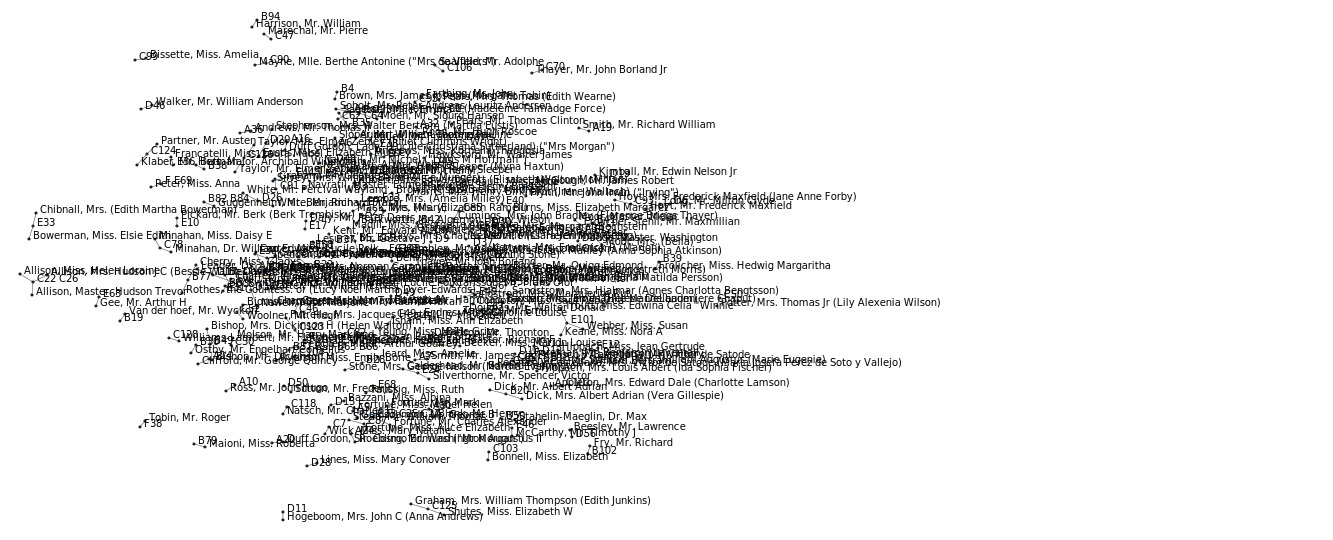

In [18]:
draw_graph(nx.k_core(B, 1), show_names=True)

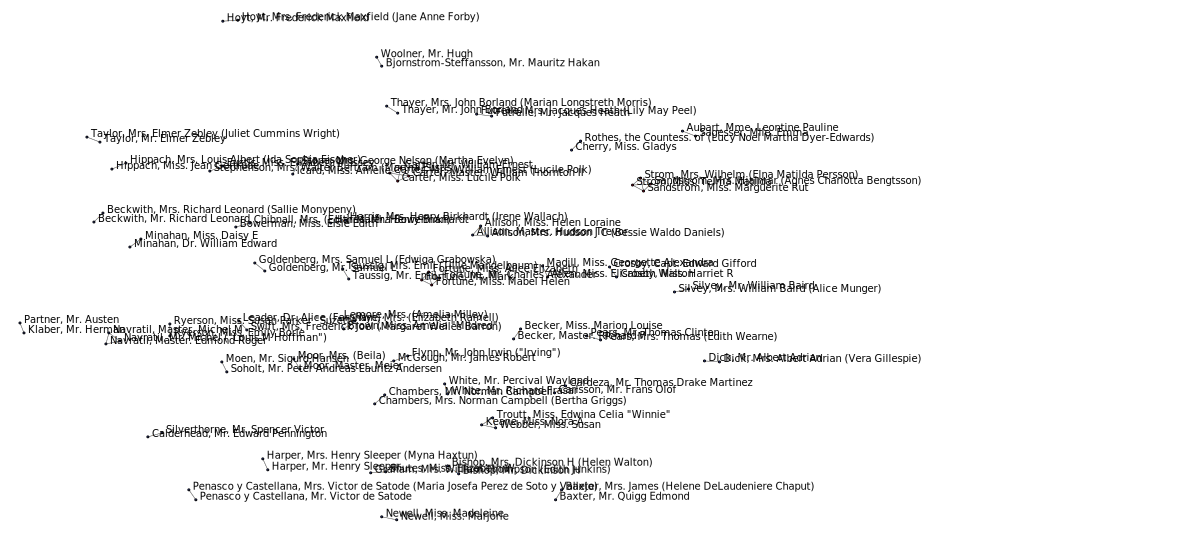

In [19]:
draw_graph(nx.k_core(G, 1), show_names=True)

In [20]:
degree_df = pd.DataFrame(G.degree)
degree_df.columns = ['name', 'degrees']

degree_df.head()

,name,degrees
0,"Braund, Mr. Owen Harris",0
1,"Heikkinen, Miss. Laina",0
2,"Allen, Mr. William Henry",0
3,"Moran, Mr. James",0
4,"Palsson, Master. Gosta Leonard",0


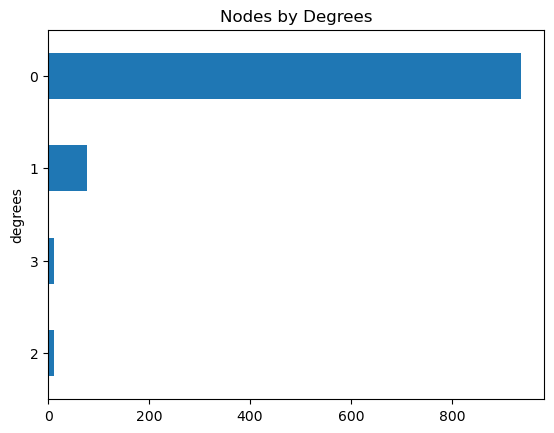

In [21]:
degree_df['degrees'].value_counts().plot.barh(title='Nodes by Degrees').invert_yaxis()

# Components (Families)

In [22]:
components = list(nx.connected_components(G))

In [23]:
show_component_count(components, 2)

c: 693 - len: 4
c: 701 - len: 4
c: 715 - len: 3
c: 731 - len: 3
c: 739 - len: 3
c: 794 - len: 3
c: 831 - len: 4


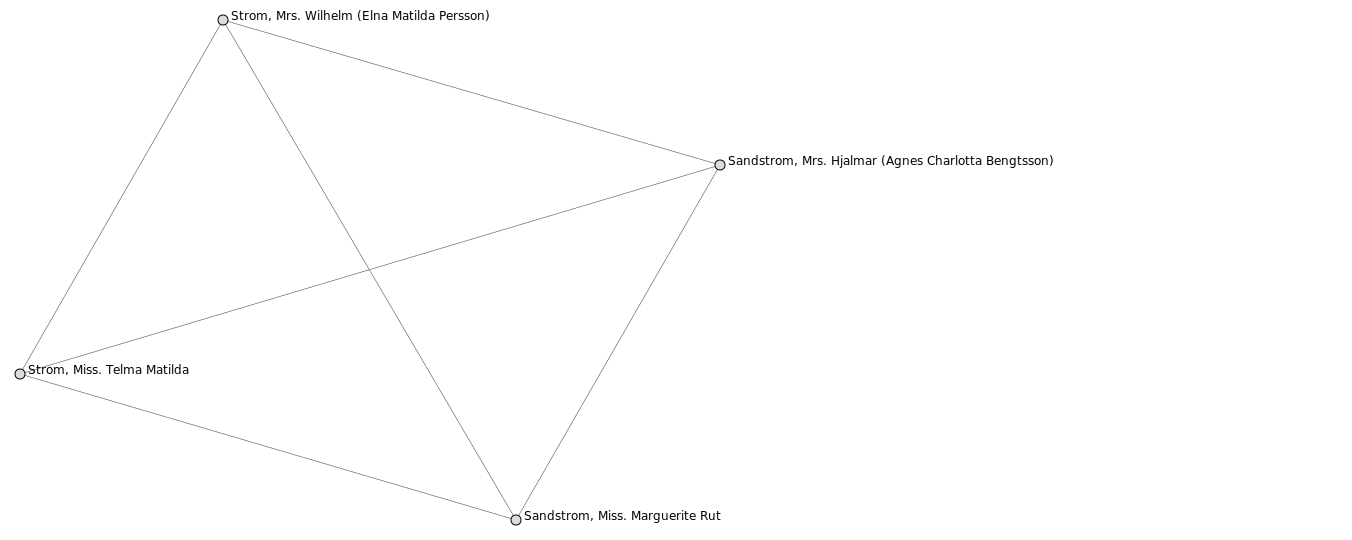

In [24]:
draw_component(G, components[693])

# what is their story? find it on wiki

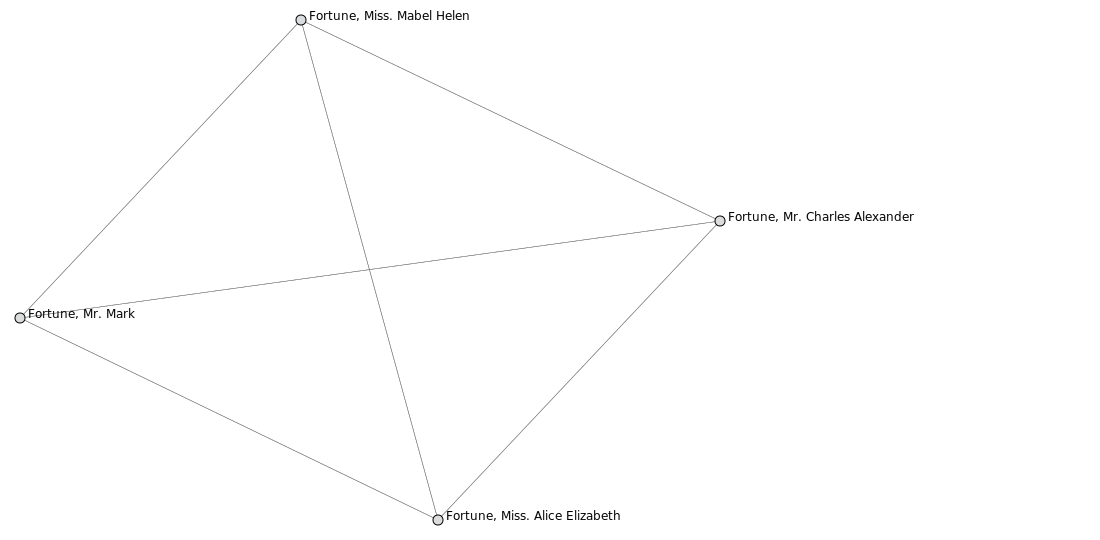

In [25]:
draw_component(G, components[701])

# what is their story?

# Graph Node Vectors

In [29]:
#!pip install karateclub

In [30]:
from networkx.algorithms import bipartite

B = nx.from_pandas_edgelist(net_df, source='name', target='cabin')
B.remove_nodes_from(['unknown', 'F', 'D', 'T'])
G = bipartite.projected_graph(B, B.nodes)

In [27]:
from karateclub.node_embedding.neighbourhood.randne import RandNE

G_numeric = nx.convert_node_labels_to_integers(G, first_label=0, ordering='default', label_attribute=None)

model = RandNE()
model.fit(G_numeric)

embeddings = model.get_embedding() 

eb_df = pd.DataFrame(embeddings, index=G.nodes) 
eb_df.reset_index(inplace=True)

columns = ['g_eb_' + str(c) for c in eb_df.columns]
eb_df.columns = columns

eb_df.rename(columns={'g_eb_index':'name'}, inplace=True)

eb_df.head(5) 

ModuleNotFoundError: No module named 'karateclub'

# Putting it Together

In [58]:
df.head(1)

,pclass,name,sex,age,sibsp,parch,fare,embarked,cabin,cabin_count,survived,age_child,age_child_small,age_child_tiny,possible_mother_present,possible_father_present,room_adult_supervision
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.25,S,unknown,1,0,0,0,0,1,1,1


In [59]:
eb_df.head(1)

,name,g_eb_0,g_eb_1,g_eb_2,g_eb_3,g_eb_4,g_eb_5,g_eb_6,g_eb_7,g_eb_8,...,g_eb_118,g_eb_119,g_eb_120,g_eb_121,g_eb_122,g_eb_123,g_eb_124,g_eb_125,g_eb_126,g_eb_127
0,"Braund, Mr. Owen Harris",-0.439196,-0.151547,-0.591281,-1.700467,0.350091,-0.230692,-1.517646,-0.716878,0.24523,...,0.733903,0.915927,-0.911352,-1.189143,0.909951,1.303552,-0.45782,1.775928,-1.247407,0.509843


In [60]:
keep_cols = ['name', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked', 'cabin_count', 'survived', 'age_child', 
             'age_child_small', 'age_child_tiny', 'possible_mother_present', 'possible_father_present', 
             'room_adult_supervision']

slim_df = df[keep_cols].copy()
slim_df.head()

,name,pclass,sex,age,sibsp,parch,embarked,cabin_count,survived,age_child,age_child_small,age_child_tiny,possible_mother_present,possible_father_present,room_adult_supervision
0,"Braund, Mr. Owen Harris",3,male,22.0,1,0,S,1,0,0,0,0,1,1,1
1,"Heikkinen, Miss. Laina",3,female,26.0,0,0,S,1,1,0,0,0,1,1,1
2,"Allen, Mr. William Henry",3,male,35.0,0,0,S,1,0,0,0,0,1,1,1
3,"Moran, Mr. James",3,male,NaN,0,0,Q,1,0,0,0,0,1,1,1
4,"Palsson, Master. Gosta Leonard",3,male,2.0,3,1,S,1,0,1,1,1,1,1,1


In [61]:
from sklearn.preprocessing import LabelEncoder

X_df = slim_df.merge(eb_df, left_on='name', right_on='name', how='inner')

le = LabelEncoder()
X_df['sex'] = le.fit_transform(X_df['sex'])
X_df['embarked'] = le.fit_transform(X_df['embarked'])


X_df.drop_duplicates(inplace=True)
X_df.reset_index(drop=True, inplace=True)

X_df.dropna(inplace=True)

X_cols = [c for c in X_df.columns if c is not 'survived' and c is not 'name']

X = X_df[X_cols]
y = X_df['survived']

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1337, test_size=0.2) 

clf = RandomForestClassifier(random_state=1337) 
clf.fit(X_train, y_train) 

train_acc = clf.score(X_train, y_train) 
test_acc = clf.score(X_test, y_test) 

print('train accuracy: {}\ntest accuracy: {}'.format(train_acc, test_acc))

train accuracy: 1.0
test accuracy: 0.7622377622377622


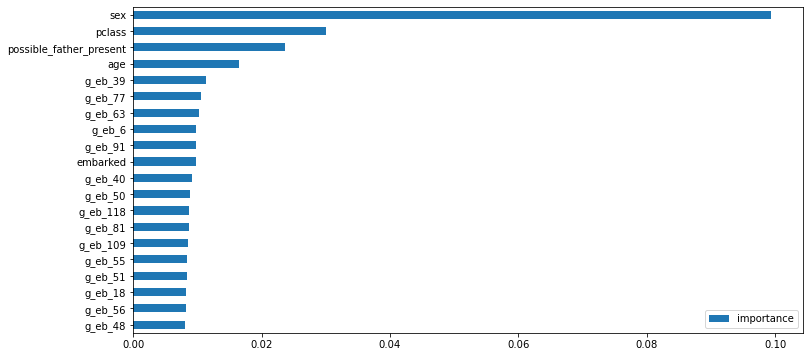

In [67]:
importances = clf.feature_importances_

importance_df = pd.DataFrame(importances, index=clf.feature_names_in_)
importance_df.columns = ['importance']

importance_df.sort_values('importance', ascending=False, inplace=True)


importance_df[0:20].plot.barh(figsize=(12,6)).invert_yaxis()

In [75]:
X_tiny = X[['sex', 'pclass', 'possible_father_present', 'age', 'embarked']]

X_train, X_test, y_train, y_test = train_test_split(X_tiny, y, random_state=1337, test_size=0.2) 

clf = RandomForestClassifier(random_state=1337, max_features=4, max_depth=6) 
clf.fit(X_train, y_train) 

train_acc = clf.score(X_train, y_train) 
test_acc = clf.score(X_test, y_test) 

print('train accuracy: {}\ntest accuracy: {}'.format(train_acc, test_acc))

train accuracy: 0.8686514886164624
test accuracy: 0.8251748251748252


In [ ]:
#this will be the day one blog, network approach to getting started

In [ ]:
# observations:

# cabins field has multiple cabins
# if split cabins on space, then have the number of cabins a family is using. cabin_count can be a useful feature
# if divide family size by cabin count, may be able to tell roughly how many people are in each room

# do people with more rooms (wealth) survive more?
# how is survivability at each k_corona? each level they are a part of
# how is survivability by degrees, or density

# each room should be a dense network of family members
# build a network of rooms, then attach family members, then drop rooms
# check survivability by room, and initial letter of room